**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups#, fetch_mldata

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from scipy.spatial.distance import minkowski, cdist
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.train_labels = y
        self.train_data = X
            
        return self
            
    def predict(self, X):
        axis_0, axis_1 = self.train_data.shape
        if self.n_neighbors < 0:
            raise ValueError("n_neighbors must be greater than 0")
            
        elif self.n_neighbors >= axis_0:
            raise ValueError("n_neighbors must be greater or at least equal than the num of training data")
        
        if self.algorithm == 'brute':
            distances = cdist(X, self.train_data, metric='minkowski')
            ind_k_near = np.argpartition(distances, (self.n_neighbors - 1), axis=1)[:, :self.n_neighbors]
            labels = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, self.train_labels[ind_k_near])
        else:
            for i in np.arange(X.shape[0]):
                tmp_matrix = np.concatenate((X[i][np.newaxis, :], self.train_data))
                tree = KDTree(tmp_matrix)
                ind_k_near = tree.query(tmp_matrix[0, np.newaxis], k=(self.n_neighbors + 1), return_distance=False)
                if i == 0:
                    ind = ind_k_near[0, 1:][np.newaxis, :]
                else:
                    ind = np.concatenate((ind, ind_k_near[0, 1:][np.newaxis, :]))
            labels = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, self.train_labels[ind - 1])
            
        return labels

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(n_neighbors=2)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.05 ms, sys: 1.25 ms, total: 2.31 ms
Wall time: 4.9 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 10 µs


MyKNeighborsClassifier(n_neighbors=2)

In [11]:
%time clf.predict(X_test)

CPU times: user 3.04 ms, sys: 1.89 ms, total: 4.94 ms
Wall time: 5.62 ms


array([1, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 0, 1, 0])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 1.7 ms, sys: 1.47 ms, total: 3.17 ms
Wall time: 1.86 ms


array([1, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 0, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 944 µs, sys: 256 µs, total: 1.2 ms
Wall time: 1.11 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [17]:
%time clf.predict(X_test)

CPU times: user 3.05 ms, sys: 1.21 ms, total: 4.26 ms
Wall time: 4.62 ms


array([0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 5.19 ms, sys: 2.12 ms, total: 7.31 ms
Wall time: 7.4 ms


array([0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer(max_df=0.8)
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
clf = KNeighborsClassifier()

In [24]:
scores = cross_validate(clf, X, target, cv=3, return_train_score=True)
scores

{'fit_time': array([0.01441288, 0.02389288, 0.01677918]),
 'score_time': array([2.14669991, 1.78628707, 1.80622888]),
 'test_score': array([0.18107105, 0.17793689, 0.18827897]),
 'train_score': array([0.4494829 , 0.42277608, 0.43298422])}

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [25]:
ind = np.arange(X.shape[0])
np.random.shuffle(ind)

In [26]:
# Для CountVectorizer для двух метрик
mean_scores_min = np.zeros(10)
mean_scores_cos = np.zeros(10)
for metric in ['minkowski', 'cosine']:
    mean_scores = np.zeros(10)
    for n_neighbors in np.arange(1, 11):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        scores = cross_validate(clf, X[ind, :], target[ind], cv=3, scoring='accuracy')
        if metric == 'minkowski':
            mean_scores_min[n_neighbors - 1] = np.mean(scores['test_score'])
        else:
            mean_scores_cos[n_neighbors - 1] = np.mean(scores['test_score'])
print('minkowski: ', mean_scores_min.argmax() + 1, ';  {}'.format(mean_scores_min.max()))
print('cos: ', mean_scores_cos.argmax() + 1, ';  {}'.format(mean_scores_cos.max()))

minkowski:  1 ;  0.21575036986231644
cos:  1 ;  0.30890976596805503


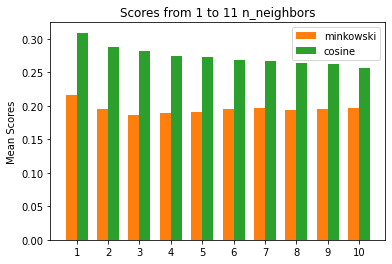

In [27]:
x = np.arange(1, 11)
width = 0.35

fig, ax = plt.subplots()

ax.bar(x, mean_scores, width)
rects1 = ax.bar(x - width/2, mean_scores_min, width, label='minkowski')
rects2 = ax.bar(x + width/2, mean_scores_cos, width, label='cosine')

ax.set_ylabel('Mean Scores')
ax.set_title('Scores from 1 to 11 n_neighbors')
ax.set_xticks(x)
ax.legend()

plt.show()

minkowski:  1 ;  0.14548332566096925
cos:  1 ;  0.6053564630973348


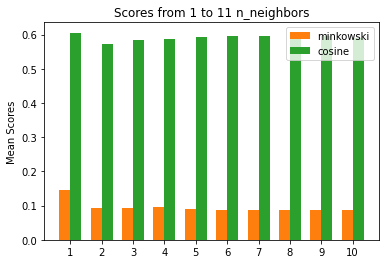

In [28]:
# Для TfidfVectorizer для двух метрик
vectorizer = TfidfVectorizer(max_df=0.8)
X = vectorizer.fit_transform(data)

mean_scores_min = np.zeros(10)
mean_scores_cos = np.zeros(10)
for metric in ['minkowski', 'cosine']:
    mean_scores = np.zeros(10)
    for n_neighbors in np.arange(1, 11):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        scores = cross_validate(clf, X[ind, :], target[ind], cv=3, scoring='accuracy')
        if metric == 'minkowski':
            mean_scores_min[n_neighbors - 1] = np.mean(scores['test_score'])
        else:
            mean_scores_cos[n_neighbors - 1] = np.mean(scores['test_score'])
print('minkowski: ', mean_scores_min.argmax() + 1, ';  {}'.format(mean_scores_min.max()))
print('cos: ', mean_scores_cos.argmax() + 1, ';  {}'.format(mean_scores_cos.max()))

x = np.arange(1, 11)
width = 0.35

fig, ax = plt.subplots()

ax.bar(x, mean_scores, width)
rects1 = ax.bar(x - width/2, mean_scores_min, width, label='minkowski')
rects2 = ax.bar(x + width/2, mean_scores_cos, width, label='cosine')

ax.set_ylabel('Mean Scores')
ax.set_title('Scores from 1 to 11 n_neighbors')
ax.set_xticks(x)
ax.legend()

plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [29]:
clf_best = KNeighborsClassifier(n_neighbors=1, metric='cosine')

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [30]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [31]:
X_test_data = newsgroups['data']
y_test_target = newsgroups['target']

In [32]:
X_test_data = vectorizer.transform(X_test_data)

In [33]:
clf_best.fit(X, target)
accuracy_score(clf_best.predict(X_test_data), y_test_target)

0.5161975570897503

In [34]:
# Возможно, количество новых слов(которые не содержатся в словаре) на тесте больше, чем когда было деление на valid